In [44]:
# Importing the required modules
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.applications import VGG19
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Flatten

In [35]:
# Path of the images (images with tumor and images with no tumor)
yes_path = r'C:\Users\arunk\Desktop\brain_tumor_dataset\yes'
no_path = r'C:\Users\arunk\Desktop\brain_tumor_dataset\no'

In [36]:
# List all files in the 'yes' directory and create full file paths
yes_files = [os.path.join(yes_path, file) for file in os.listdir(yes_path)]

# List all files in the 'no' directory and create full file paths
no_files = [os.path.join(no_path, file) for file in os.listdir(no_path)]

In [3]:
# Define data augmentation parameters
datagen = ImageDataGenerator(
    # Rotation range for random rotations (degrees)
    rotation_range=2,
    # Width shift range for random horizontal shifts (fraction of total width)
    width_shift_range=0.1,
    # Height shift range for random vertical shifts (fraction of total height)
    height_shift_range=0.1,
    # Shear range for random shearing transformations (in radians)
    shear_range=0.2,
    # Zoom range for random zoom (fraction of original size)
    zoom_range=0.2,
    # Range for adjusting brightness (tuple indicating minimum and maximum brightness factor)
    brightness_range=(0.3, 0.7),
    # Randomly flip inputs horizontally
    horizontal_flip=True,
    # Strategy for filling in newly created pixels after a rotation or a width/height shift
    fill_mode='nearest'
)

In [4]:
def save_augmented_images(directory, files):
    # Create a new directory for saving augmented images with '_augmented' suffix
    os.makedirs(directory + '_augmented', exist_ok=True)
    # Loop through each file in the provided list of files
    for file in files:
        # Load the image using load_img function from Keras, resizing it to (224, 224)
        img = load_img(file, target_size=(224, 224))
        # Convert the image to a numpy array
        img_array = img_to_array(img)
        # Reshape the image array to have a batch dimension of 1
        img_array = img_array.reshape((1,) + img_array.shape)
        # Initialize a counter for tracking the number of augmented images generated for each original image
        i = 0
        # Generate augmented images using the datagen.flow method
        # The flow method generates batches of augmented data indefinitely
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=directory + '_augmented', save_prefix='aug', save_format='jpg'):
            # Increment the counter
            i += 1
            # Limit the number of augmented images generated for each original image to 1
            if i >= 1:  
                break  # Break the loop after generating one augmented image for each original image

In [64]:
# Call the function to save augmented images for the 'yes' class
save_augmented_images(yes_path, yes_files)

In [75]:
# Call the function to save augmented images for the 'no' class
save_augmented_images(no_path, no_files)

Visualizing the image with no Tumour

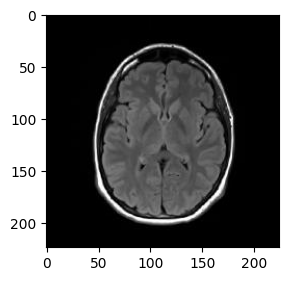

In [52]:
plt.figure(figsize=(3,4))
img = load_img(r"C:\Users\arunk\Desktop\brain_tumor_dataset\no\aug_0_2869.jpg")
plt.imshow(img)

Visualizing the image with Tumour

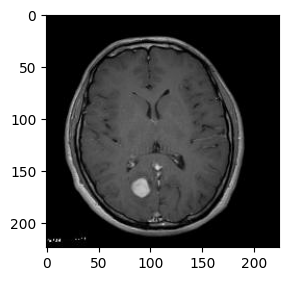

In [53]:
plt.figure(figsize=(3,4))
img = load_img(r"C:\Users\arunk\Desktop\brain_tumor_dataset\yes\aug_0_3951.jpg")
plt.imshow(img)

In [5]:
yes_files = [os.path.join(yes_path, file) for file in os.listdir(yes_path)]
no_files = [os.path.join(no_path, file) for file in os.listdir(no_path)]

In [54]:
# Print the number of files in the 'yes' directory
print('Yes :', len(yes_files))

# Print the number of files in the 'no' directory
print('No  :', len(no_files))


Yes : 760
No  : 671


In [55]:
# Create a list of zeros with length equal to the number of files in the 'yes' directory
yes_labels = [0] * len(yes_files)

# Create a list of ones with length equal to the number of files in the 'no' directory
no_labels = [1] * len(no_files)

In [56]:
print(yes_labels[:5])
print(no_labels[:5])

[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1]


In [57]:
# Combine the lists of labels for 'yes' and 'no' into a single list
# This will result in a list where the first set of labels corresponds to 'yes' and the second set corresponds to 'no'
target = yes_labels + no_labels

In [46]:
print(target[:5])
print(target[-5:])

[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1]


C:\Users\arunk\AppData\Local\Temp\ipykernel_11196\4292201753.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target,palette=colors)


<Axes: ylabel='count'>

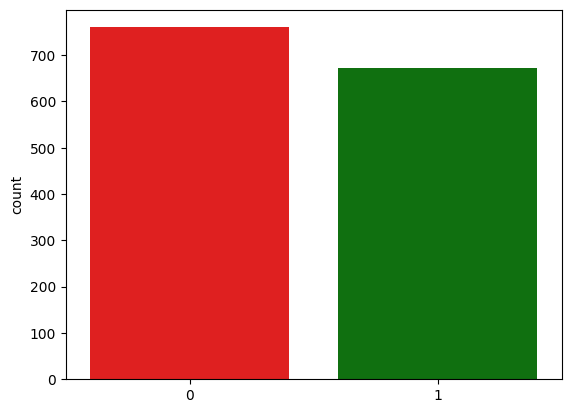

In [43]:
colors=['red','green']
sns.countplot(x=target,palette=colors)

In [58]:
data = []  # Create an empty list to store image data along with their labels

# Loop through each image file path and its corresponding label
for path, label in zip(yes_files + no_files, target):
    # Load the image using load_img function from Keras, resizing it to (224, 224)
    img = load_img(path, target_size=(224, 224))
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Append the image array and its label as a tuple to the 'data' list
    data.append((img_array, label))

In [59]:
#  Shuffle the data to randomize the order of images and labels
np.random.shuffle(data)

In [60]:
# Create an array 'x' containing the image data from the 'data' list
x = np.array([item[0] for item in data])

# Create an array 'y' containing the labels from the 'data' list
y = np.array([item[1] for item in data])

In [12]:
# Convert the image data type to float32 and scale the pixel values to the range [0, 1]
x = x.astype(np.float32) / 255.0

In [61]:
# Define the input shape for the VGG19 model, which is (224, 224, 3)
inp_shape = (224, 224, 3)

# Load the VGG19 model with pre-trained ImageNet weights, excluding the top (classification) layers
vgg19 = VGG19(input_shape=inp_shape, weights='imagenet', include_top=False)

# Set all layers of the VGG19 model to non-trainable (freeze their weights)
for layer in vgg19.layers:
    layer.trainable = False

In [62]:
# Define the model architecture using a Sequential model
model = Sequential([
    # Add the VGG19 convolutional base as the first layer
    vgg19,  
    # Flatten the output of the VGG19 convolutional base
    Flatten(),  
    # Add a Dense layer with a single neuron and sigmoid activation function for binary classification
    Dense(1, activation='sigmoid')  
])

In [15]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
# Fitting the data into the model
model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_test, y_test))

36/36 ━━━━━━━━━━━━━━━━━━━━ 385s 11s/step - accuracy: 0.8662 - loss: 0.3362 - val_accuracy: 0.8397 - val_loss: 0.3550


In [23]:
# Save the weights of the model
model.save_weights('brain_tumour.weights.h5')

In [65]:
# Load the trained model weights
model.load_weights('brain_tumour.weights.h5')

In [70]:
# Function to preprocess image before prediction
def preprocess_image(image_path):
    # Load the image from the provided image_path and resize it to (224, 224)
    img = load_img(image_path, target_size=(224, 224))
    
    # Convert the image to a numpy array and scale pixel values to the range [0, 1]
    img_array = img_to_array(img) / 255.0
    
    # Add a batch dimension to the image array
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

# Function to predict tumor based on the provided image
def predict_tumor(image_path):
    # Preprocess the image
    preprocessed_img = preprocess_image(image_path)
    
    # Make a prediction using the preprocessed image and the loaded model
    prediction = model.predict(preprocessed_img)
    
    # Check if the predicted probability is greater than 0.5
    if prediction[0][0] > 0.5:
        return "No tumor detected"
    else:
        return "Tumor detected"

Prediction (For no tumour)

In [73]:
# Path to the image to be predicted
image_path = r"C:\Users\arunk\Desktop\brain_tumor_dataset\no\22 no.jpg"

# Perform tumor prediction on the provided image
prediction = predict_tumor(image_path)

# Print the prediction result
print("Result :", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Result : No tumor detected


Prediction (For tumour)

In [74]:
# Path to the image to be predicted
image_path = r"C:\Users\arunk\Desktop\brain_tumor_dataset\yes\aug_0_2250.jpg"

# Perform tumor prediction on the provided image
prediction = predict_tumor(image_path)

# Print the prediction result
print("Result:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Result: Tumor detected
